# PaDEL - PaDEL-Descriptor for molecular fingerprints


## Introduction


Description of the files:
- Header: The first three lines are the header, containing the molecule name or ID , program information, and comments.
- Counts Line: Mentions the number of atoms, bonds, and other structural features.
- Atom Block: This is a list of all the atoms in the molecule. Each line represents one atom and specifies its properties in columns:
    - Atom serial number: The atom's x, y, and z coordinates.
    - The element symbol (e.g., C for carbon, O for oxygen).
- Bond Block: This block follows the atoms and defines how they are connected. Each line represents one bond:
    - Column 1: The index number of the first atom in the bond (from the Atom Block).
    - Column 2: The index number of the second atom.
    - Column 3: The bond type (e.g., 1 = single, 2 = double).

After the bond block, there are additional sections that gives more information about the molecule.

## Extraction of Zips files


In [1]:
import sys
import numpy as np
import pandas as pd

print("Python Executable:", sys.executable)
print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)

# Make sure the executable path contains "gspan_env"
assert "gspan_env" in sys.executable

Python Executable: c:\Users\Rodrigo\Desktop\Seminarios\AIDataMiningS1\gspan_env\Scripts\python.exe
Python Version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
NumPy Version: 1.23.5
Pandas Version: 1.5.3


In [ ]:
# Dependencies (uncomment to install)

%pip install rdkit
#%pip install padelpy
%pip install py3Dmol
%pip install gspan-mining
%pip install "pandas<2.0"

In [2]:
import os
import gzip
import shutil

# Define paths
source_dir = 'datasets/SDFssmallset/'   
dest_dir = 'datasets/SDFssmallset_extracted/'

# Create folder
os.makedirs(dest_dir, exist_ok=True)

# Loop through each file in the source directory
for filename in os.listdir(source_dir):
    # Check if the file is a .gz file
    if filename.endswith('.sdf.gz'):
        # Construct the full file paths
        source_path = os.path.join(source_dir, filename)
        # Create the new filename by removing .gz
        output_filename = filename[:-3] 
        dest_path = os.path.join(dest_dir, output_filename)

        print(f"Extracting {filename} to {dest_dir}...")

        # Open the compressed file and write the extracted content to the destination
        with gzip.open(source_path, 'rb') as f_in:
            with open(dest_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    

print("\nExtraction complete!")

Extracting 10077147.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10096043.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10113978.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10172943.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10184653.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10302451.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10341154.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10384072.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10390396.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 10461815.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 104842.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 11316960.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 11327430.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 11360391.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 11364421.sdf.gz to datasets/SDFssmallset_extracted/...
Extracting 1

## Pre-Processing

### Transforming SDF to Visualizable Format

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
import glob

input_folder = "datasets/SDFssmallset_extracted/"

output_folder = "datasets/molecule_images/"
os.makedirs(output_folder, exist_ok=True)

# Get all .sdf
sdf_files = glob.glob(os.path.join(input_folder, "*.sdf"))

for sdf_file in sdf_files:
    suppl = Chem.SDMolSupplier(sdf_file)
    mol = suppl[0] 
    
    if mol is None:
        print(f"Warning: Could not read molecule from {sdf_file}")
        continue

    base_name = os.path.basename(sdf_file)
    file_name_without_ext = os.path.splitext(base_name)[0]
    png_filename = f"{file_name_without_ext}.png"
    output_path = os.path.join(output_folder, png_filename)

    Draw.MolToFile(mol, output_path, size=(500, 500))

print(f"\nFinished")



Finished


### Random Split of Molecules

In [28]:
from rdkit import Chem
import glob
import os
import random

input_folder = "datasets/SDFssmallset_extracted/"
sdf_files = glob.glob(os.path.join(input_folder, "*.sdf"))

all_mols = []
for file in sdf_files:
    suppl = Chem.SDMolSupplier(file)
    for mol in suppl:
        if mol is not None:
            all_mols.append(mol)

# Shuffle the list of molecules
random.shuffle(all_mols)

# Split the list into two halves
split_point = len(all_mols) // 2
group_a_mols = all_mols[:split_point]
group_b_mols = all_mols[split_point:]


print(f"Total molecules: {len(all_mols)}")
print(f"Group A size: {len(group_a_mols)}")
print(f"Group B size: {len(group_b_mols)}")

Total molecules: 105
Group A size: 52
Group B size: 53


### Saving Split Molecules

In [29]:
from pathlib import Path

def mol_to_gspan_lines(mol, graph_id):
    lines = []
    lines.append(f"t # {graph_id}")
    
    # Add atoms (vertices)
    for atom in mol.GetAtoms():
        lines.append(f"v {atom.GetIdx()} {atom.GetAtomicNum()}")
    
    # Add bonds (edges)
    for bond in mol.GetBonds():
        # Identify bond type as an integer label
        bond_label = int(bond.GetBondTypeAsDouble())
        lines.append(f"e {bond.GetBeginAtomIdx()} {bond.GetEndAtomIdx()} {bond_label}")
    return lines

def save_gspan_file(mol_list, filename):
    with open(filename, 'w') as f:
        for i, mol in enumerate(mol_list):
            lines = mol_to_gspan_lines(mol, i)
            f.write("\n".join(lines) + "\n")
    print(f"Saved gSpan database to {filename}")

out_dir = Path("datasets/moleculesSplit")
out_dir.mkdir(parents=True, exist_ok=True)

# Create the two database files
save_gspan_file(group_a_mols, "datasets/moleculesSplit/Sgroup_A.gspan")
save_gspan_file(group_b_mols, "datasets/moleculesSplit/Sgroup_B.gspan")

Saved gSpan database to datasets/moleculesSplit/Sgroup_A.gspan
Saved gSpan database to datasets/moleculesSplit/Sgroup_B.gspan


## Processing

In [30]:
# Execute the commands in the virtual environment
!python -m gspan_mining -s 35 -l 7 -u 10 -d False -v False -p False -w True datasets/moleculesSplit/Sgroup_A.gspan > results_A.txt
!python -m gspan_mining -s 35 -l 7 -u 10 -d False -v False -p False -w True datasets/moleculesSplit/Sgroup_B.gspan > results_B.txt

c:\Users\Rodrigo\Desktop\Seminarios\AIDataMiningS1\gspan_env\Lib\site-packages\gspan_mining\gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(
c:\Users\Rodrigo\Desktop\Seminarios\AIDataMiningS1\gspan_env\Lib\site-packages\gspan_mining\gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(
c:\Users\Rodrigo\Desktop\Seminarios\AIDataMiningS1\gspan_env\Lib\site-packages\gspan_mining\gspan.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._report_df = self._report_df.append(
c:\Users\Rodrigo\Desktop\Seminarios\AIDataMiningS1\gspan_env\Lib\site-packages\gspan_mining\gspan.py:336: FutureWarning: The frame.append method is dep

Found 23 unique frequent subgraphs in results_A.txt
Found 18 unique frequent subgraphs in results_B.txt

Found 8 subgraphs frequent in A but NOT frequent in B:
----------------------------------------------------------------
t # 5
5
v 0 6
v 1 6
v 2 6
v 3 6
v 4 6
v 5 6
v 6 6
v 7 6
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 4 7 1
e 5 6 1

Support: 37
where: [0, 1, 2, 3, 5, 7, 8, 9, 13, 14, 15, 16, 17, 19, 20, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49]

-----------------
Support in A: 37
-----------------
t # 7
7
v 0 6
v 1 6
v 2 6
v 3 6
v 4 6
v 5 6
v 6 6
v 7 7
v 8 6
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1
e 6 7 1
e 7 8 1

Support: 36
where: [0, 1, 3, 5, 7, 8, 9, 10, 13, 15, 17, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 44, 45, 46, 47, 48, 49, 50]

-----------------
Support in A: 36
-----------------
t # 6
6
v 0 6
v 1 6
v 2 6
v 3 6
v 4 6
v 5 6
v 6 6
v 7 7
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1
e 6 7 

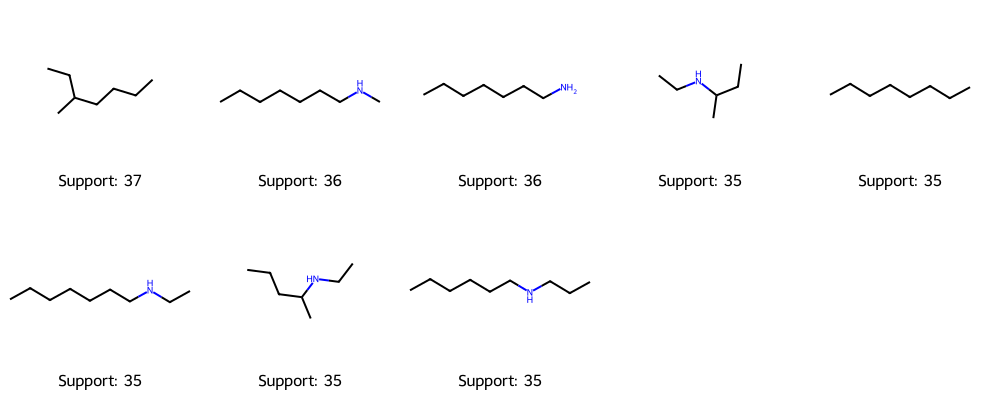

In [ ]:
import re
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display # Make sure display is imported

# --- Configuration & Constants ---
FILE_A = 'results_A.txt'
FILE_B = 'results_B.txt'
MAX_IMAGES_TO_SHOW = 25
MOLS_PER_ROW = 5
SUB_IMG_SIZE = (200, 200)

BOND_TYPE_MAP = {
    '1': Chem.BondType.SINGLE,
    '2': Chem.BondType.DOUBLE,
    '3': Chem.BondType.TRIPLE,
    '4': Chem.BondType.AROMATIC
}

# Regex patterns for parsing lines
RE_VERTEX = re.compile(r"v\s+(\d+)\s+([\w\d]+)") # Group 1: ID, Group 2: Label
RE_EDGE = re.compile(r"e\s+(\d+)\s+(\d+)\s+([\w\d]+)") # Group 1: ID1, Group 2: ID2, Group 3: Label
RE_SUPPORT = re.compile(r"Support:\s+(\d+)") # Group 1: Count
RE_WHERE = re.compile(r"where:\s+\[(.*?)\]") # Group 1: Comma-separated IDs


def parse_subgraph_block(block_lines):
    """Parses a block of text lines into vertices, edges, support, and where."""
    vertices, edges = [], []
    support, where_list = -1, []
    
    for line in block_lines:
        match = RE_VERTEX.match(line)
        if match:
            vertices.append((int(match.group(1)), match.group(2))) # (id, label_str)
            continue
        match = RE_EDGE.match(line)
        if match:
            u, v = sorted((int(match.group(1)), int(match.group(2))))
            edges.append((u, v, match.group(3))) # (id1, id2, label_str)
            continue
        match = RE_SUPPORT.search(line)
        if match:
            support = int(match.group(1))
            continue
        match = RE_WHERE.search(line)
        if match:
            where_list = [int(x.strip()) for x in match.group(1).split(',') if x.strip()]

    # Sort for canonical representation
    vertices.sort(key=lambda x: (x[1], x[0]))
    edges.sort()
    return vertices, edges, support, where_list

def get_canonical_string(vertices, edges):
    """Creates a unique string representation of the subgraph."""
    v_str = "|".join([f"v{vid}:{vlbl}" for vid, vlbl in vertices])
    e_str = "|".join([f"e{u}-{v}:{elbl}" for u, v, elbl in edges])
    return f"{v_str}##{e_str}"

def read_fsm_results(filename):
    """Reads a gSpan/ParSeMiS output file and returns a dict of subgraphs."""
    subgraphs = {}
    try:
        with open(filename, 'r') as f:
            content = f.read()
        
        # Split into blocks based on 't #' separator, ignoring empty blocks
        blocks = [block.strip() for block in content.split('t #') if block.strip()]
        
        for i, block_content in enumerate(blocks):
            # Add back 't #' line for context if needed, though parse doesn't use it now
            lines = ['t # ' + str(i)] + block_content.splitlines() 
            vertices, edges, support, where = parse_subgraph_block(lines)
            if vertices or edges: # Ensure block wasn't empty
                canonical_str = get_canonical_string(vertices, edges)
                subgraphs[canonical_str] = {
                    'block': "\n".join(lines), # Store original text block
                    'support': support,
                    'vertices': vertices,
                    'edges': edges,
                    'where': where
                }
    except FileNotFoundError:
        print(f"Error: File not found - {filename}")
    return subgraphs

def subgraph_to_mol(vertices, edges):
    """Converts parsed subgraph vertices/edges to an RDKit mol."""
    mol = Chem.RWMol()
    node_map = {}
    try:
        for original_id, vlabel_str in vertices:
            atom = Chem.Atom(int(vlabel_str)) # Assume label is atomic number
            rdkit_idx = mol.AddAtom(atom)
            node_map[original_id] = rdkit_idx

        for u, v, elabel_str in edges:
            if u in node_map and v in node_map:
                bond_type = BOND_TYPE_MAP.get(elabel_str, Chem.BondType.SINGLE)
                mol.AddBond(node_map[u], node_map[v], bond_type)
            else:
                 print(f"Warning: Edge ({u}-{v}) refers to unknown vertex ID. Skipping edge.")

        Chem.SanitizeMol(mol)
        return mol.GetMol() # Return read-only version
    except ValueError as ve:
         print(f"Warning: Could not parse atom/bond label: {ve}")
         return None
    except Exception as e:
        print(f"Error converting subgraph to RDKit Mol: {e}")
        return None

# --- Main Comparison Logic ---

subgraphs_a = read_fsm_results(FILE_A)
subgraphs_b = read_fsm_results(FILE_B)

print(f"Found {len(subgraphs_a)} unique frequent subgraphs in {FILE_A}")
print(f"Found {len(subgraphs_b)} unique frequent subgraphs in {FILE_B}")

unique_keys_a = set(subgraphs_a.keys()) - set(subgraphs_b.keys())

print(f"\nFound {len(unique_keys_a)} subgraphs frequent in A but NOT frequent in B:")
print("-" * 64)

mols_to_draw, legends = [], []

if not unique_keys_a:
    print("No unique frequent subgraphs found for Group A.")
else:
    # Sort keys by support in A, descending
    sorted_unique_keys = sorted(unique_keys_a, key=lambda k: subgraphs_a[k]['support'], reverse=True)
    
    for key in sorted_unique_keys:
        data = subgraphs_a[key]
        print(data['block'].strip())
        print(f"Support in A: {data['support']}")
        print("-" * 17)
        
        mol = subgraph_to_mol(data['vertices'], data['edges'])
        if mol:
            mols_to_draw.append(mol)
            legends.append(f"Support: {data['support']}")

# --- Visualization ---
if mols_to_draw:
    print("\nVisualizations of Subgraphs Unique to Group A (Sorted by Support):")
    img = Draw.MolsToGridImage(
        mols_to_draw[:MAX_IMAGES_TO_SHOW],
        molsPerRow=MOLS_PER_ROW,
        subImgSize=SUB_IMG_SIZE,
        legends=legends[:MAX_IMAGES_TO_SHOW]
    )
    display(img)
    if len(mols_to_draw) > MAX_IMAGES_TO_SHOW:
        print(f"(Showing first {MAX_IMAGES_TO_SHOW} of {len(mols_to_draw)} unique subgraphs)")
else:
    print("\nCould not generate visualizations for unique subgraphs.")